# Brief overview of seawater equation of state

The equation of state relates in situ density with temperature, salinity and pressure.

\begin{align}
\rho = \rho(temperature, salinity, p)
\end{align}

It turns out, there are multiple definition of density, temperature and salinity (details found [here](http://www.teos-10.org)). 

The temperature measured by thermometers is called the in situ temperature. 

The density required to compute the Archimedes' force on an underwater float is called the in situ density.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import gsw

import cognac.ufloat as fl

---

We load a profile collected during a field campaign that took place in the mediterranean sea in september 2018.

In [2]:
dp = pickle.load(open( 'CTD4.p', 'rb' ))
d = dp['d']
d = d[d.index>1]
d.head()

,pressure,temperature,salinity,conductivity,flag
pressure,,,,,
2.0,1.923875,24.519125,38.384763,57.055303,0.0
3.0,2.890562,24.517131,38.384600,57.053255,0.0
4.0,4.107000,24.513594,38.384338,57.049486,0.0
5.0,4.878250,24.512600,38.384325,57.048744,0.0
6.0,6.094813,24.508900,38.384369,57.045169,0.0


Text(0.5,0,'PSU')

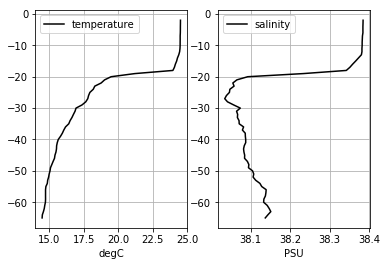

In [3]:
#d.plot(subplots=True)
ax=plt.subplot(121)
ax.plot(d['temperature'],-d.index,'k',label='temperature')
ax.legend()
ax.grid()
ax.set_xlabel('degC')
ax=plt.subplot(122)
ax.plot(d['salinity'],-d.index,'k',label='salinity')
ax.legend()
ax.grid()
ax.set_xlabel('PSU')

In [4]:
# derive absolute salinity and conservative temperature
lon, lat = 6., 42.5
p = d.index
SA = gsw.SA_from_SP(d['salinity'], p, lon, lat)
CT = gsw.CT_from_t(SA, d['temperature'], p)

---

We compute next the true in situ density and compare it with that ignoring temperature, salinity and pressure variations

In [5]:
# compute in situ density
rho = gsw.density.rho(SA, CT, p)

In [6]:
# compute density for constant temperature
rho_noT = gsw.density.rho(SA, CT[0]+0.*CT, p)
# compute density for constant salinity
rho_noS = gsw.density.rho(SA[0]+0.*SA, CT, p)
# compute density for constant pressure
rho_nop = gsw.density.rho(SA, CT, p[0]+0.*p)

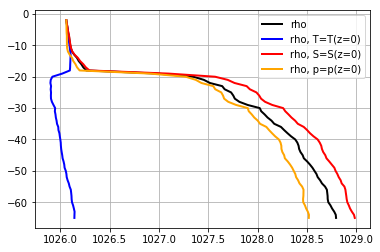

In [7]:
plt.figure()

plt.plot(rho, -p, 'k', lw=2, label='rho')
plt.plot(rho_noT, -p, 'blue', lw=2, label='rho, T=T(z=0)')
plt.plot(rho_noS, -p, 'red', lw=2, label='rho, S=S(z=0)')
plt.plot(rho_nop, -p, 'orange', lw=2, label='rho, p=p(z=0)')
plt.grid()
plt.legend()

Temperature dominates the seawater density in the present case with minor contributions from pressure and salinity

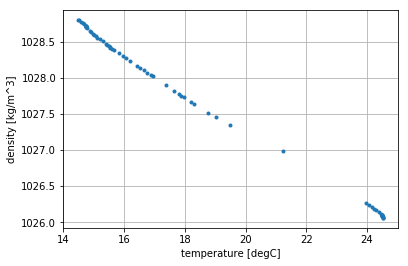

In [8]:
ax = plt.subplot(111)
ax.plot(d['temperature'], rho, '.', lw=2)
ax.set_xlabel('temperature [degC]')
ax.set_ylabel('density [kg/m^3]')
ax.grid()

We use ENSTA's float volume to quantify in mg the equivalent mass change associated with hydrography

Text(0.5,1,'equivalent mass change [mg] for a 5.6e+03 cm^3')

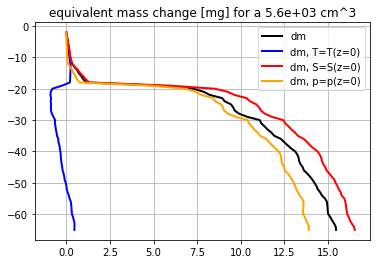

In [9]:
V = 5.65e+03 # cm^3 / milliliters

sc = 1e-3
ax = plt.subplot(111)
ax.plot((rho-rho[0])*V*sc, -p, 'k', lw=2, label='dm')
ax.plot((rho_noT-rho_noT[0])*V*sc, -p, 'blue', lw=2, label='dm, T=T(z=0)')
ax.plot((rho_noS-rho_noS[0])*V*sc, -p, 'red', lw=2, label='dm, S=S(z=0)')
ax.plot((rho_nop-rho_nop[0])*V*sc, -p, 'orange', lw=2, label='dm, p=p(z=0)')
ax.grid()
ax.legend()
ax.set_title('equivalent mass change [mg] for a %.1e cm^3'%V)

In [10]:
# derivatives
rho, alpha, beta = gsw.rho_alpha_beta(SA, CT, p)
rho_SA, rho_CT, rho_P = gsw.rho_first_derivatives(SA, CT, p)
print('drho/dSA = %.1e (kg/m^3)/(g/kg)' %rho_SA.mean())
print('drho/dCT = %.1e (kg/m^3)/degC' %rho_CT.mean())
print('drho/dP = %.1e (kg/m^3)/dbar' %(rho_P.mean()/1e-4))

drho/dSA = 7.5e-01 (kg/m^3)/(g/kg)
drho/dCT = -2.5e-01 (kg/m^3)/degC
drho/dP = 4.3e-03 (kg/m^3)/dbar


---

# back to float dynamics

In [11]:
from float_lib import *

Provided water profile at lon=6, lat=42


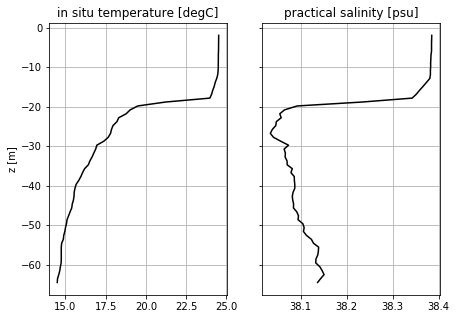

In [12]:
# select a water profile
w = waterp(pressure=p.tolist(), temperature=d['temperature'].tolist(), 
           salinity=d['salinity'].tolist(), 
           lon=lon,lat=lat)
print(w)

In [13]:
# Init now active control of the vertical position

#
z=np.arange(-100.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = autonomous_float(model='ENSTA')

# compute compressibility
gamma=compute_gamma(f.a,.005,material='polycarbonat')
print('Float compressibility = %e /dbar \n' %(gamma))
f.gamma=gamma

# adjust mass to be at equilibrium at -25m
iz = np.argmin(np.abs(z+25))
f.adjust_m(p[iz],temp[iz],rho_w[iz])

# set vmax such that the float has an extra buoyancy at the surface equal
# to a cylinder ot 2cm radius and height of 10cm (antenna casing)
iz = np.argmin(np.abs(z+0.))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz]) + .1*np.pi*.02**2
# use d_max to prescribe piston max course
dmax = .07

#
f.init_piston(d_max=dmax,vol_max=vmax,vol=vmax)
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

Float compressibility = 9.300000e-05 /dbar 

143.2 g were added to the float in order to be at equilibrium at 25 dbar 

Piston max displacement set from max volume
Float parameters: 
  L     = 0.50 m      - float length
  2a    = 0.12 m      - float diameter
  m     = 5.80 kg     - float radius
  V     = 5.65e+03 cm^3   - float volume
  gamma = 9.30e-05 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
Piston parameters and state: 
  2a    = 50.00 mm        - piston diameter
  phi   = 0.00 rad       - present angle of rotation
  d     = 0.00 mm        - present piston displacement
  vol   = 122.18 cm^3      - present volume addition
  lead  = 1.75 cm        - screw lead
  phi_max = 2513.27 deg     - maximum rotation
  phi_min = 0.00 deg     - minimum rotation
  d_max = 70.00 mm        - maximum piston displacement
  d_min = 0.00 mm        - minimum piston displacement
  vol_min = -15.26 cm^3    - mi

In [14]:

# adjust piston to be at equilibrium 20m
iz = np.argmin(np.abs(z+20.))
vmax = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) ) # check

# compute float vertical displacement associated with 1mm piston displacement
f.piston.update_d(f.piston.d+.001)
f.piston_update_vol()
print('z equilibrium after 1 mm piston displacement = %.1fm' %(f.z4equilibrium(w) ) )

Piston reset : vol=-6.2e-01 cm^3  
z equilibrium = -6.7m
z equilibrium after 1 mm piston displacement = -10.6m


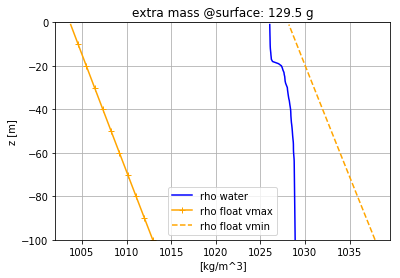

In [15]:
# show densities
plot_float_density(z, f, w)

---

## look at one profile in the ocean

WOA water profile at lon=6, lat=40
WOA water profile at lon=-30, lat=30


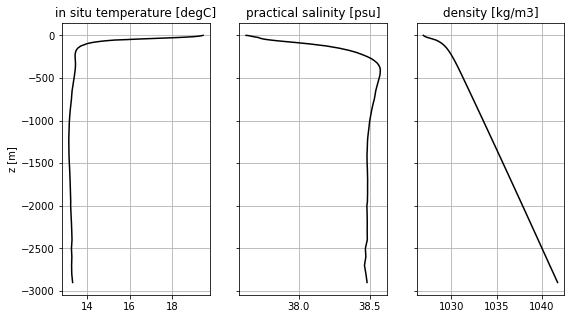

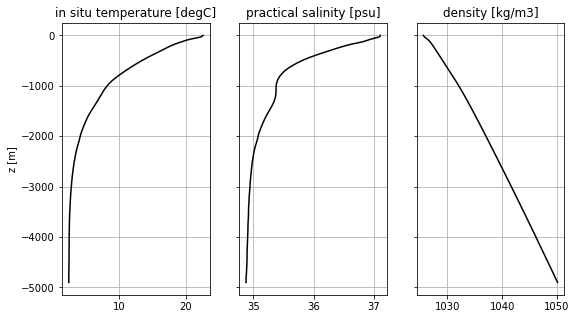

In [2]:
# select a water profile
#w = fl.waterp(lon=-50.,lat=40.) # Gulf Stream
w_med = fl.waterp(lon=6.,lat=40.) # Mediterranean sea
w_atl = fl.waterp(lon=-30.,lat=30.) # Central Atlantic
print(w_med)
print(w_atl)

In [3]:
#
f = fl.autonomous_float(model='Ifremer')
f.init_piston()
#f.m = f.m - 5e-3
print(f)

Piston max volume set from max displacement
Float parameters: 
  L     = 0.83 m      - float length
  r     = 0.07 m      - float radius
  m     = 11.63 kg     - float mass
  V     = 1.27e+04 cm^3   - float volume
  rho_cte = m/V = 9.13e+08 kg.cm^3   - float baseline density
  gamma = 3.78e-06 /dbar  - mechanical compressibility
  gamma x V = 4.82e-02 cm^3/dbar  - normalized compressibility
  alpha = 6.98e-05 /degC  - thermal compressibility
  alpha x V = 8.89e-01 cm^3/degC  - normalized thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 0.97 cm        - piston radius
  d     = 0.00 cm        - present piston displacement
  vol   = 26.88 cm^3      - present volume addition
  d_increment  = 8.57e-02 mm        - smallest variation of translation motion for the p

In [4]:
z=np.arange(-1000.,0.,1.)

def plot(w):
    
    rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

    # adjust mass to be at equilibrium at 0m and substract 5g
    f.init_piston()
    iz = np.argmin(np.abs(z+0))
    f.adjust_m(p[iz], temp[iz], rho_w[iz], offset=-5)

    # adjust piston to be at equilibrium -1m
    z0 = -1.
    iz = np.argmin(np.abs(z-z0))
    vstart = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
    print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) )

    # show densities
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    fl.plot_float_density(z, f, w, ax=ax[0])
    fl.plot_float_volume(z, f, w, ax=ax[1])
    _ = fl.plot_equilibrium_volume(f, w)

Piston max volume set from max displacement
1496.5 g  were added to the float in order to be at equilibrium at 1 dbar 

Piston reset for equilibrium : vol=2.2e+01 cm^3  
z equilibrium = -1.0m


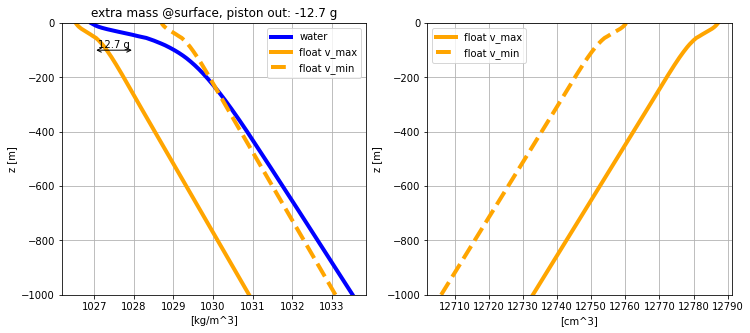

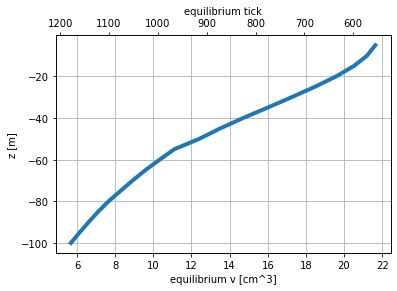

In [5]:
plot(w_med)

Piston max volume set from max displacement
-13.4 g  were added to the float in order to be at equilibrium at 1 dbar 

Piston reset for equilibrium : vol=2.2e+01 cm^3  
z equilibrium = -1.0m


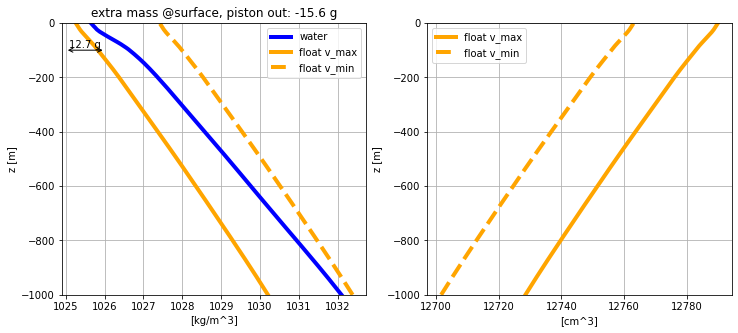

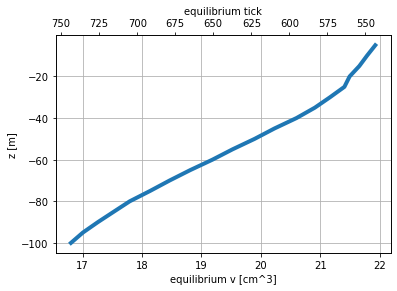

In [6]:
plot(w_atl)

In [7]:
# cm3

w = w_med

depth = 100
print('volume change for required at {:d} m depth : {:.1f} cm^3'
      .format(depth, (w.get_compressibility(z).mean()-f.gamma)*depth*f.V*1e6)
     )

dT = 1.
print('volume change for required at {:.1f} degC temperature change : {:.1f} cm^3'
      .format(dT, (w.get_alpha(z).mean()-f.alpha)*dT*f.V*1e6)
     )

dS = 1.
print('volume change for required at {:.1f} psu salinity change : {:.1f} cm^3'
      .format(dT, (w.get_beta(z).mean())*dS*f.V*1e6)
     )



volume change for required at 100 m depth : 0.6 cm^3
volume change for required at 1.0 degC temperature change : 1.9 cm^3
volume change for required at 1.0 psu salinity change : 9.4 cm^3


In [17]:
# 
w = w_med

print('gamma_water = {:.3} /dbar'.format(w.get_compressibility(z).mean()) )
print('alpha_water = {:.3} /degC'.format(w.get_alpha(z).mean()) )
print('beta_water = {:.3} /psu'.format(w.get_beta(z).mean()) )


gamma_water = 4.23e-06 /dbar
alpha_water = 0.000216 /degC
beta_water = 0.000739 /psu


---

# payload Argo float

Ignoring water stratification:

$
\begin{align}
V_p = V \times p \delta \gamma
\end{align}
$

where $V_p$ is the piston volume, $V$ the overall platform volume (float + payload), $\delta \gamma$ the compressibility difference, $p$ the pressure.

For $V_p=2$ liter, an incompressible platform ($\delta \gamma = \gamma_{water}=4.0~10^{-6}$/dbar) and, $p=4000$ dbar: $V=125$ liters which is a cube of 50 cm width.

For $p=1000$ dbar: $V=500$ liter or a cube of 80 cm width.

For $p=500$ dbar: $V=1000$ liter or a cube of 1 m width.



In [26]:
2/(4e-6*4e3)

125.0

In [33]:
(2/(4e-6*4e3)*1e-3)**(1./3)

0.5

In [37]:
(0.5)**(1/3)

0.7937005259840998